# Regression(회귀)

## Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
<br><br>
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

In [52]:
# import 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchinfo import summary


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. 데이터 준비

In [3]:
# Data 읽어오기
df = pd.read_csv("data/boston_hosing.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [79]:
# X,y 분리 
X_boston = df.drop(columns ="MEDV").values   # DataFrame -> ndarray
y_boston = df["MEDV"].values.reshape(-1,1)

X_boston.shape, y_boston.shape
X_boston.dtype, y_boston.dtype

# dtype변경   - linear 계산시 dtype 맞추기?
X_boston = X_boston.astype("float32")
y_boston = y_boston.astype("float32")
X_boston.dtype, y_boston.dtype



(dtype('float32'), dtype('float32'))

In [80]:
# train, test 분리 
X_train, X_test, y_train, y_test = train_test_split(X_boston, y_boston, test_size= 0.2, random_state= 0)
# 회귀니까 stratify 지정안함


In [81]:
# Feature scaling  (Feature간의 scaling 값의 범위 통일)
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
# Dataset 생성  - TensorDataset

trainset = TensorDataset(torch.tensor(X_train_scaled), torch.tensor(y_train))
testset = TensorDataset(torch.tensor(X_test_scaled), torch.tensor(y_test))

In [83]:
# DataLoader 생성

train_loader = DataLoader(trainset, 200, shuffle= True, drop_last= True)

test_loader = DataLoader(testset, len(testset)) # train과 같은 수로 batch 줄 필요 없음


print("step 수 ", len(train_loader), len(test_loader)) # step : 한 epoch을 도는 데 걸리는 batch 수 

step 수  2 1


# 2. 모델 정의 

In [84]:
print(X_train_scaled.shape)
print(y_train.shape)

(404, 13)
(404, 1)


In [70]:
class BostonModel(nn.Module):

    def __init__(self):
        # 1. 부모 클래스의 __init__() 호출해 초기화 (필수)
        super().__init__()
        # instance 변수 초기화 : forward()에서 사용할 함수들(Layer) 초기화
        self.lr1 = nn.Linear(in_features= 13, out_features= 32)
        self.lr2 = nn.Linear(32,16)
        self.lr3 = nn.Linear(16,1)
        self.relu = nn.ReLU() # FCL(nn.Linear)로 구성된 딥러닝 모델 -> 비선형성 주기

    def forward(self, X):
        out = self.lr1(X)
        out = self.relu(out)
        out = self.lr2(out)
        out = self.relu(out)
        out = self.lr3(out)  
        #추정할 값의 scale에 따라 activation 함수 사용 가능 
        # 0-1로 압축 : logistic 함수(nn.Sigmoid), -1~1로 압축: hyperbolic tangent(nn.Tanh)
        return out
        

In [71]:
# 모델 instance 생성
model = BostonModel()

In [72]:
# 모델 구조 확인 
print(model)


BostonModel(
  (lr1): Linear(in_features=13, out_features=32, bias=True)
  (lr2): Linear(in_features=32, out_features=16, bias=True)
  (lr3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [73]:
summary(model,(100,13)) # (batch, feature 수 )

# 파라미터 수 
# 13*32 + 32 = 448
# 32*16 + 16(bias) = 528

# 일대일 전연결

Layer (type:depth-idx)                   Output Shape              Param #
BostonModel                              [100, 1]                  --
├─Linear: 1-1                            [100, 32]                 448
├─ReLU: 1-2                              [100, 32]                 --
├─Linear: 1-3                            [100, 16]                 528
├─ReLU: 1-4                              [100, 16]                 --
├─Linear: 1-5                            [100, 1]                  17
Total params: 993
Trainable params: 993
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05

In [74]:
# 모델에서 layer 함수를 조회
layer1 = model.lr1
w1= layer1.weight
b1 = layer1.bias

# 모델의 전체 weight와 parameter들 -> optimizer에 모델의 파라미터 전달 
## generator : 반복할 때마다 layer 순서대로 weight, bias 전달
model.parameters()

<generator object Module.parameters at 0x000001F128C92F80>

In [75]:
w1.dtype, b1.dtype

(torch.float32, torch.float32)

#  3. Train - 학습 +검증

In [85]:
# 하이퍼파라미터 정의 
EPOCHS = 1000
LR = 0.001     # 학습율 ; optimizer에 설정 

# model, loss 함수, optimizer 준비
model = BostonModel().to(device) # device로 옮기기
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(
    model.parameters(),  
    lr = LR
)

In [86]:
# train + evalutation

import time 

train_loss_list = []
valid_loss_list = []

# 1 epoch 학습 2 단계 : train(train_loader) -> 검증(test_loader)
s= time.time()

for epoch in range(EPOCHS):
    # epoch별 처리 
    ############################
    # 학습
    ############################
    # 1. train 모드 변경
    model.train()
    train_loss = 0.0
    for X_train, y_train in train_loader: # batch 단위로 학습
        # 한 step 학습 
        # 1. device로 옮기기
        X_train, y_train = X_train.to(device), y_train.to(device)
        # 2. 모델 추정 
        pred_train = model(X_train)
        # 3. loss 계산
        loss = loss_fn(pred_train, y_train)
        # 4. loss 기준 gradient 계산 
        loss.backward()
        # 5. 파라미터 업데이트
        optimizer.step()
        # 6. 파라미터 초기화
        optimizer.zero_grad()
        # 7. 로그출력을 위한 loss 누적
        train_loss += loss.item() # batch의 loss 누적
    train_loss/=len(train_loader) # epoch별 train_loss 평균
    
    ############################
    # 검증
    ############################
    # 1. eval 모드 변경
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            #1. device로 옮기기 
            X_val, y_val = X_val.to(device), y_val.to(device)
            #2. 모델 추정 
            pred_val = model(X_val)
            #3. 검증
            loss = loss_fn(pred_val, y_val)
            # 4. batch별 loss 누적
            valid_loss += loss.item()
        valid_loss /= len(test_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    print(f"[{epoch+1:04d}/{EPOCHS} train loss : {train_loss} valid loss : {valid_loss}]")


e= time.time()
print(f"학습에 걸린 시간: {s-e}초")

[0001/1000 train loss : 595.2448120117188 valid loss : 565.4071044921875]
[0002/1000 train loss : 585.9095153808594 valid loss : 555.9436645507812]
[0003/1000 train loss : 575.192626953125 valid loss : 545.0020141601562]
[0004/1000 train loss : 563.1127014160156 valid loss : 531.947998046875]
[0005/1000 train loss : 545.4125061035156 valid loss : 515.2933349609375]
[0006/1000 train loss : 528.6676940917969 valid loss : 497.0140075683594]
[0007/1000 train loss : 506.63575744628906 valid loss : 478.1819152832031]
[0008/1000 train loss : 486.9810791015625 valid loss : 458.66363525390625]
[0009/1000 train loss : 456.0754852294922 valid loss : 438.7998352050781]
[0010/1000 train loss : 440.2146759033203 valid loss : 418.537353515625]
[0011/1000 train loss : 416.29296875 valid loss : 398.17633056640625]
[0012/1000 train loss : 395.63584899902344 valid loss : 377.76873779296875]
[0013/1000 train loss : 372.5266418457031 valid loss : 357.7056579589844]
[0014/1000 train loss : 352.1427001953125

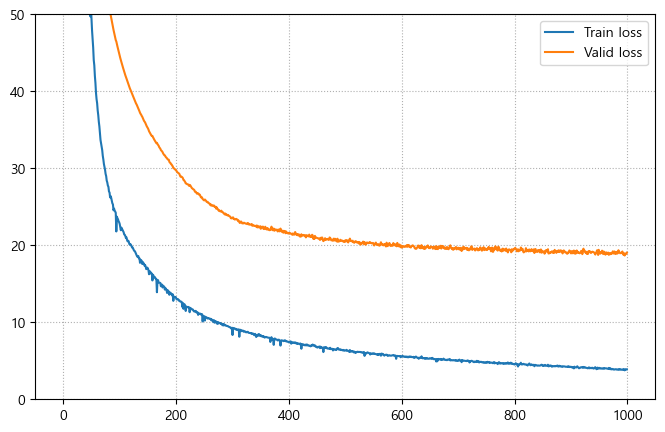

In [92]:
### 학습 결과 시각화

plt.figure(figsize = (8,5))
plt.plot(range(EPOCHS), train_loss_list, label = "Train loss")
plt.plot(range(EPOCHS), valid_loss_list, label = "Valid loss")
plt.grid(True, linestyle=":")
plt.ylim(0,50)
plt.legend()
plt.show()

In [94]:
### 모델 저장 
boston_model_save_path = "saved_models/boston_model.pth"
torch.save(model, boston_model_save_path)

In [95]:
### 저장된 모델 로드
load_model = torch.load(boston_model_save_path)
print(load_model)

BostonModel(
  (lr1): Linear(in_features=13, out_features=32, bias=True)
  (lr2): Linear(in_features=32, out_features=16, bias=True)
  (lr3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [103]:
### 새로운 데이터 추정 
new_data= torch.tensor(X_test_scaled[:5])

with torch.no_grad():
    y_hat = load_model(new_data)

In [104]:
y_test[:5]

array([[22.6],
       [50. ],
       [23. ],
       [ 8.3],
       [21.2]], dtype=float32)

In [105]:
y_hat

tensor([[22.9891],
        [27.5494],
        [23.5253],
        [11.0426],
        [17.6864]])